# Working with Panda Dataframe, based on tutorial provided by TensorFlow.

This tutorial uses a weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

We will first begin by unzipping the file.

In [1]:
import zipfile

with zipfile.ZipFile('Data/jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('Data/jena_climate_2009_2016/')

We will be reading the csv file using panda dataframe

In [2]:
import pandas as pd

csv_path = 'Data/jena_climate_2009_2016/jena_climate_2009_2016.csv'
df = pd.read_csv(csv_path)

This tutorial will just deal with hourly predictions, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [3]:
# Slice [start:stop:step], starting from index 5 take every 6th record. array-style slicing
df = df[5::6]

# Let's remove the datetime value and make it into a separate variable
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


To quickly examine the first few rows of the data, we can use the following command-df.head(). We can also use df.tail() to read the last five rows of the data.

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Now, let's plot some of the data.

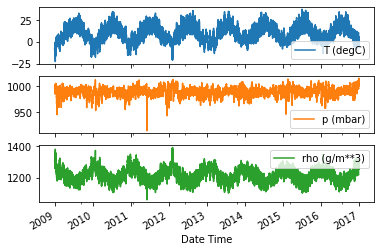

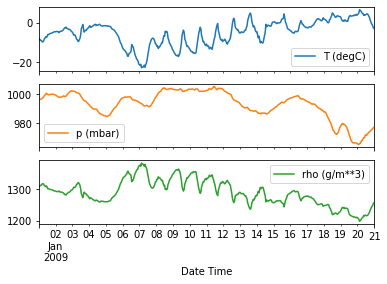

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

An advantage of using panda dataframe is that we can quickly obtain the data statistics. This can be useful to spot for outliers within our data.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


From our table above, we noticed that the wind speed (wv) and max. wv has unrealistic values (-9999). These outliers need to be removed from our data by substituting with zero.

In [7]:
# We will first identify the index of the bad data and then replace them with zero
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are then reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

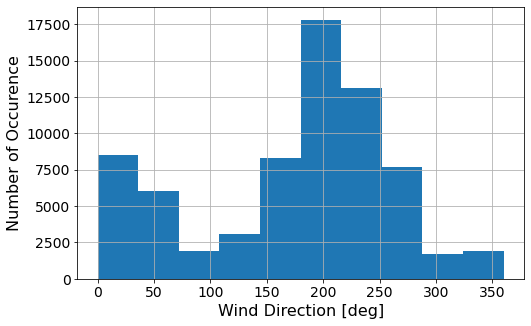

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(8, 5))
plt.hist(df['wd (deg)'])
plt.xlabel('Wind Direction [deg]', fontsize=16)
plt.ylabel('Number of Occurence', fontsize=16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.grid()

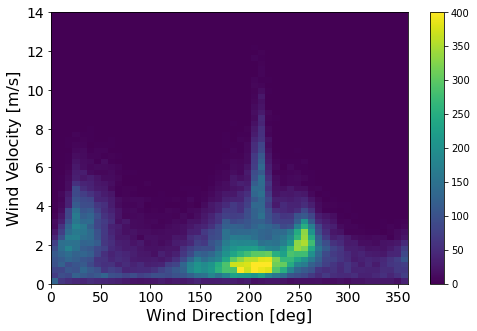

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(8, 5))
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]', fontsize=16)
plt.ylabel('Wind Velocity [m/s]', fontsize=16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Assignment 1: Visualize the density values along the trajectory of the CHAMP satellite for the first 50 days in 2002
Trajectory of CHAMP in year 2002 - Data interpolation - https://zenodo.org/record/4602380#.Ys--Fy-B2i5

## Part 1: Extract hourly position location (local solar time, lattitude, altitude) from the daily CHAMP data to obtain the hourly trajectory of the CHAMP satellite in 2002

### Hint 1: How to identify dir path to files of interest

In [2]:
import os

datalist2 = [os.path.join("Data/Champ_dens_2002/", file) for file in os.listdir("Data/Champ_dens_2002/") if file.endswith(".txt")]

datalist = []
for file in os.listdir("Data/Champ_dens_2002/"):
    if file.endswith(".txt"):
        datalist.append(os.path.join("Data/Champ_dens_2002/", file))

# Practice: Do this using list comprehension        
# After getting the file path, sort it in increasing order        
sortedChampdata = sorted(datalist)

assert len(sortedChampdata) == 180

### Hint 2: How to read a tab delimited text file

In [69]:
import pandas as pd

header_label = ['GPS Time (sec)','Geodetic Altitude (km)','Geodetic Latitude (deg)','Geodetic Longitude (deg)','Local Solar Time (hours)','Velocity Magnitude (m/s)','Surface Temperature (K)','Free Stream Temperature (K)','Yaw (rad)','Pitch (rad)','Proj_Area_Eric (m^2)','CD_Eric (~)','Density_Eric (kg/m^3)','Proj_Area_New (m^2)','CD_New (~)','Density_New (kg/m^3)','Density_HASDM (kg/m^3)','Density_JB2008 (kg/m^3)' ]
df=pd.read_csv('Data/Champ_dens_2002/CHAMP_Density_02_001_v2.txt', delim_whitespace=True, header=None, skiprows=1)
df.columns = header_label
df.head()

,GPS Time (sec),Geodetic Altitude (km),Geodetic Latitude (deg),Geodetic Longitude (deg),Local Solar Time (hours),Velocity Magnitude (m/s),Surface Temperature (K),Free Stream Temperature (K),Yaw (rad),Pitch (rad),Proj_Area_Eric (m^2),CD_Eric (~),Density_Eric (kg/m^3),Proj_Area_New (m^2),CD_New (~),Density_New (kg/m^3),Density_HASDM (kg/m^3),Density_JB2008 (kg/m^3)
0,0.0,411.103,84.295,-122.957,15.799,7657.209,300.0,1305.112,-0.027,0.012,0.604,3.861,5.364000e-12,0.893,3.120,4.486000e-12,7.785000e-12,5.019000e-12
1,10.0,411.322,84.853,-119.556,16.029,7656.958,300.0,1304.478,-0.026,0.012,0.599,3.888,5.230000e-12,0.890,3.131,4.374000e-12,7.711000e-12,4.971000e-12
2,20.0,411.539,85.389,-115.340,16.313,7656.708,300.0,1303.784,-0.025,0.011,0.594,3.896,5.015000e-12,0.886,3.142,4.173000e-12,7.307000e-12,5.580000e-12
3,30.0,411.754,85.892,-110.047,16.668,7656.462,300.0,1303.029,-0.024,0.011,0.590,3.924,4.730000e-12,0.882,3.154,3.935000e-12,7.238000e-12,5.517000e-12
4,40.0,411.968,86.351,-103.346,17.118,7656.217,300.0,1302.210,-0.023,0.010,0.585,3.952,4.421000e-12,0.878,3.165,3.677000e-12,7.170000e-12,5.447000e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,86350.0,458.958,-80.227,43.494,2.882,7603.142,300.0,1320.750,0.015,0.003,0.533,4.461,3.398000e-12,0.831,3.363,2.891000e-12,4.071000e-12,2.951000e-12
8636,86360.0,458.845,-80.837,44.571,2.957,7603.256,300.0,1323.829,0.014,0.003,0.530,4.487,3.377000e-12,0.829,3.367,2.877000e-12,4.095000e-12,2.969000e-12
8637,86370.0,458.725,-81.443,45.807,3.042,7603.379,300.0,1326.879,0.013,0.003,0.527,4.513,3.345000e-12,0.827,3.371,2.855000e-12,4.118000e-12,2.988000e-12
8638,86380.0,458.598,-82.044,47.235,3.140,7603.511,300.0,1329.900,0.012,0.003,0.524,4.540,3.312000e-12,0.824,3.375,2.832000e-12,4.142000e-12,3.008000e-12


### Hint 3: Data slicing (Identifying data index of interest and extracting the relevant data (local solar time, lattitude, altitude))

In [70]:
import numpy as np

idx_interest = np.where(df['GPS Time (sec)']== 10)[0] # get index of data that satisfy our condition
print(df['Geodetic Altitude (km)'][idx_interest])

1    411.322
Name: Geodetic Altitude (km), dtype: float64


### Hint 4: The remainder operator is given by % and might be useful.

In [71]:
arr = np.linspace(1,20,20)
print(arr%5)

[1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0.]


## Assignment 1 (b): Load the date that we have used in the morning and use 3d interpolation to obtain the density values along CHAMP's trajectory

### Hint 1: Follow the instruction from the morning section and use RegularGridInterpolator from the scipy.interpolate package

In [74]:
from scipy.interpolate import RegularGridInterpolator

# First create a set of sample data that we will be using 3D interpolant on
def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z

x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

sample_data = f(xg, yg, zg)

In [75]:
# Generate Interpolant (interpolating function)
my_interpolating_function = RegularGridInterpolator((x, y, z), sample_data)

In [76]:
# Say we are interested in the points [[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]]
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
my_interpolating_function(pts)

array([125.80469388, 146.30069388])

## Assignment 1(c): Visualize the density along the CHAMP's trajectory as a function of time

## Assignment 1(d): Now do it using the TIE-GCM density data and plot both density variation under the same figure

## Assignment 1(e): The plots look messy. Let's calculate the daily average density and plot those instead. 

Hint: Use np.reshape and np.mean

## Assignment 1(f): Load the accelerometer derived density from the CHAMP data (Density_New (kg/m^3)). Calculate the daily mean density and plot this value together with the JB2008 density and TIE-GCM density calculated above.

## Assignment 2: Make a python function that will parse the inputs to output the TIE-GCM density any arbritary position (local solar time, latitude, altitude) and an arbritary day of year and hour in 2002